# Decision Trees from Scratch Part 2
> This is the second post in a series to build a random forest regressor from scratch. In this post we will add a predict method to our DecisionTree class.

- toc: true
- badges: false
- comments: true
- categories: [python, from_scratch, ml]
- author: Manuel Mai
- image: images/crystal_ball.jpg

## Introduction
In the [previous post](https://blog.manuelmai.com/python/from_scratch/ml/2020/06/28/Decision_Trees_from_Scratch.html) we developed a simple, non-optimized version of a fitting method for a decision tree for regression. In this post we will add a `predict` method.

## Predicting a Sample

We are focused on the regression problem here, so predicting the `y` value of a sample row `x` means tracing the tree based on the splits and then predicting `self.value` once we reach a leaf node.
```python
def predict_row(self,row):
    # assume 'row' is a DF row or numpy array
    # check if it's a leaf node, then return mean of y for this node
    if self.score == float('inf'): return self.value
    # Otherwise check variable split and move down the correct branch of the tree
    t = self.left if row[self.var] <= self.split else self.right
    return t.predict_row(row)
```

The `predict_row(x)` method is written recursively and we start with the behavior at a leaf node, because it's very easy. If we are at the leaf node, we simply predict `sel.val` of that node which was set up to be the mean `y` of all training samples that ended up in this node. If we are not at a leaf node, we need to go deeper down the tree.  

The way we do it is to trace down the variable split for this node, which will exist by definition because we are not at a leaf node. The index of the split variable is stored in `self.var` and the split value in `self.split`. We now have all the pieces in place to go down the proper branch of the tree. If the split variable `x[self.var]` is less than or equal to the split value `self.split` we go to the left sub-tree a call `predict_row` on that node, otherwise we will go right. 

That is all the recursion does. It will go down the tree until eventually we hit a leaf node and we return `self.value` as the prediction for this particular row `x`.

Now the final step to do is to implement prediction on an entire `DataFrame` x. The idea is very simple. The predict method will just return an array of all the predictions for each row.

```python

def predict(self,x):
    return np.array([self.predict_row(row) for row in x.to_numpy()])
```

## Completed Class

Let's take a look at the completed class that we have assembled so far.

In [198]:
def sum_squares(x_vals,x_sq):
    return np.sum(x_sq - np.mean(x_vals)**2) 

class DecisionTree():
    def __init__(self,x,y,idxs=None,min_leaf_size=5,max_tree_depth=3):
        self.x,self.y,self.min_leaf_size,self.max_tree_depth = x,y,min_leaf_size,max_tree_depth
        self.idxs = np.arange(len(y)) if idxs is None else idxs
        self.n_rows, self.n_cols = len(self.idxs),self.x.shape[1]
        self.val = np.mean(self.y[self.idxs])
        self.score = float('inf')
        self.find_varsplit()
    
    #go through all variables and find a variable split 
    def find_varsplit(self):
        if self.max_tree_depth > 0:
            for i in range(self.n_cols): self.find_better_split(i)
        if self.score == float('inf'): return # no split was found
        self.left = DecisionTree(self.x,self.y,self.left_idxs,max_tree_depth=self.max_tree_depth-1)
        self.right = DecisionTree(self.x,self.y,self.right_idxs,max_tree_depth=self.max_tree_depth-1)
            
    # find a split that achieves a lower score than the one we already have
    def find_better_split(self,i):
        y = self.y[self.idxs]
        y_sq = y*y
        col_data = self.x.iloc[self.idxs,i]
        for x_val in self.x.iloc[self.idxs,i].unique():
            left_ss,right_ss = float('inf'),float('inf')
            f_left = col_data <= x_val
            f_right = col_data > x_val
            if np.sum(f_left) > 0: left_ss = sum_squares(y[f_left],y_sq[f_left])
            if np.sum(f_right) > 0: right_ss = sum_squares(y[f_right],y_sq[f_right])
            if self.score > left_ss+right_ss: 
                self.score,self.var,self.split = left_ss+right_ss,i,x_val
                self.left_idxs,self.right_idxs = self.idxs[f_left],self.idxs[f_right]
    
    # predict y values for a data frame x
    def predict(self,x):
        return np.array([self.predict_row(row) for row in x.to_numpy()])

    def predict_row(self,row):
        # assume 'row' is a DF row
        # check if it's a leaf node, then return mean of y for this node
        if self.score == float('inf'): return self.val
        # Otherwise check variable split and move down the correct branch of the tree
        t = self.left if row[self.var] <= self.split else self.right
        return t.predict_row(row)
    
    #print a nice representation of the tree instance
    def __repr__(self):
        s = f'val: {self.val}, n_rows: {self.n_rows}, n_cols: {self.n_cols}'
        if self.score != float('inf'):
            s+= f', var: {self.x.columns[self.var]}, split: {self.split}'
        return s

When we initialize the class with data `x,y` we start fitting a tree. Now we can use a validation or test set and predict new values `y_new` from a new input set `x_new` by `calling predict(x_new)`, pretty cool! Let's try it out.

# Test on Synthetic Data

In [199]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Generate a synthetic data set and split into train and test sets.

In [200]:
np.random.seed(42)
x = pd.DataFrame(np.random.rand(150,3))
x.columns = ['x'+str(i) for i in range(3)]
y = np.array(x['x0']+x['x1']*10+x['x2']*20)

x_train = x[:100]
y_train = y[:100]

x_test = x[100:]
y_test = y[100:]

In [201]:
DT = DecisionTree(x_train,y_train,max_tree_depth=4)

In [202]:
y_pred = DT.predict(x_test)

Let's visually inspect the predictions.

Text(0.5, 1.0, 'Prediction vs. Test Labels')

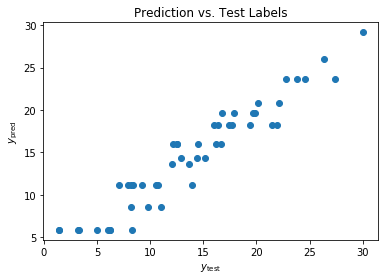

In [203]:
plt.scatter(y_test,y_pred)
plt.xlabel('$y_{\\rm test}$')
plt.ylabel('$y_{\\rm pred}$')
plt.title('Prediction vs. Test Labels')

This looks like a great success! We have achieved a high correlation, and we will quantify the performance on real data once we optimize the fitting procedure.

## Next up 

Optimizing the time complexity and assembling the Random Forest.

**Photo Credit**  
<span>Preview Photo by <a href="https://unsplash.com/@lazycreekimages?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Michael Dziedzic</a> on <a href="https://unsplash.com/s/photos/predict?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>